Alterntive VAE for assignment 3

Code by Diego Pinochet adapted by the MNIST VAE example by [francois chollete](https://www.manning.com/books/deep-learning-with-python-second-edition)



import your drive into colab session

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


1- Save your P5js app to a dropbox folder
2- right click and select 'copy dropbox link'
3- Use the copied link with the code below. You need to delete everything after the .tar extension


This is using a dataset form a GAME OF LIFE simulation. 

In [ ]:
#imports
import os 
import matplotlib.pyplot as plt 
import cv2 
import numpy as np 
from tqdm import tqdm
from PIL import Image

In [ ]:
from google.colab import output

#get the dataset

#replace with your own dropbox link.
!wget https://www.dropbox.com/s/j0kjcecxxpf3x1m/4aeebe91-4990-4511-8370-71bee54e180e.tar

output.clear()

untar (decompress) the files to the images folder

In [ ]:
#untar
!mkdir imgs #mak the images folder  
!tar -xvf  '/content/4aeebe91-4990-4511-8370-71bee54e180e.tar' -C '/content/imgs'
output.clear()


tar: v: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


check sample image from DS

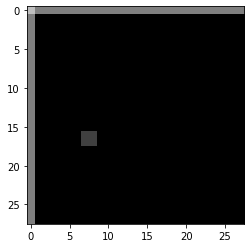

In [ ]:
sampleImage= Image.open('/content/imgs/0000015.png.png')
plt.imshow(sampleImage, cmap="Greys_r")

Process the images

If your images are larger than MNIST or include more channels such as 28x28x3, this code will format everything to 20x28x1

In [ ]:

#image to numpy array

img_data = []

#We iterate over the imgs folder, reshape the images to (28x28x1)
#and save them to the img_data array

for img in tqdm(os.listdir('/content/imgs')):
    currentImage= '/content/imgs/' + img    
    img_array = cv2.imread(currentImage)
    down_points = (28,28)
    resized_down = cv2.resize(img_array, down_points, interpolation= cv2.INTER_LINEAR) 
    gray = cv2. cvtColor(resized_down, cv2.COLOR_BGR2GRAY)
    gray = np.expand_dims(gray, 2)
    
    img_data.append(gray) 
img_data = np.array(img_data)

print(img_data[0].shape) #print the shape

100%|██████████| 10001/10001 [00:00<00:00, 13117.64it/s]

(28, 28, 1)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import output

In [ ]:
latent_dim = 2 # dimensionality of latent space

# we are starting with something that very much looks like a typical CNN
encoder_inputs = keras.Input(shape=(28, 28, 1)) # takes in a 28 x 28 image, with a single black/white channel
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

# the input image ends up being encoded in these two parameters
z_mean = layers.Dense(latent_dim, name="z_mean")(x)         # mean
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)   # variance

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")  # this is our first model
                                                                            # takes image input and outputs mean and variance in latent space

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

In [ ]:
# latent-space sampling layer

import tensorflow as tf

class Sampler(layers.Layer):
  def call(self, z_mean, z_log_var):
    batch_size = tf.shape(z_mean)[0]                          
    z_size = tf.shape(z_mean)[1]                              
    epsilon = tf.random.normal(shape=(batch_size, z_size))    
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon     # Apply the VAE sampling formula


In [ ]:

latent_inputs = keras.Input(shape=(latent_dim,))    # this is the input 

x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs) # 7*7*64=3136  it's the same number of coefficients we had at the level of Flatten layer in encoder
x = layers.Reshape((7, 7, 64))(x)   # Revert the flatten layer of the encoder
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x) # Revert the Conv2D layers. This is a reverse convolution.
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)  # The output ends with a shape (28, 28, 1), which is where encoder started
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         289 

In [ ]:
# Whenever you depart from classic supervised learning, it’s common to subclass the Model class and implement a custom train_ step()
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs): # explanation of kwargs https://realpython.com/python-kwargs-and-args/
    super().__init__(**kwargs)  # super() for inheriting from keras.Model super class https://realpython.com/python-super/
    self.encoder = encoder
    self.decoder = decoder
    self.sampler = Sampler()

    # we use these metrics to keep track of the loss averages over each epoch
    self.total_loss_tracker = keras.metrics.Mean(name="total_loss")   
    self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
    self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

  @property                  # how to use property decorator: https://www.programiz.com/python-programming/property
  def metrics(self):         # we list the metrics here in the metrics property to emable the model to reset them after each epoch            
    return [self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker]

  def train_step(self, data):
      with tf.GradientTape() as tape:           # Python 'with' used here to ensure proper release of resource
        z_mean, z_log_var = self.encoder(data)  # get z_mean (mean) and z_log_var (variance) from data input into encoder
        z = self.sampler(z_mean, z_log_var)     # use the VAE sampling formula to get z
        reconstruction = decoder(z)             # pass z to decoder
        reconstruction_loss = tf.reduce_mean(   # We sum the reconstruction loss over the spatial dimensions (axes 1 and 2) and take its mean over the batch dimension. 
            tf.reduce_sum(                      
                keras.losses.binary_crossentropy(data, reconstruction),   # input tensor to sum function. computes loss.
                axis=(1, 2)
            )
        )
        # add the regularization term (Kullback-Leibler divergence) https://www.countbayesie.com/blog/2017/5/9/kullback-leibler-divergence-explained
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))      # zip aggregates iterables in a tuple
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss":  self.kl_loss_tracker.result(),
        }


In [ ]:
import numpy as np

#(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()  # by using underscore we ignore what would typically have been y_train and y_test
#mnist_digits = np.concatenate([x_train, x_test], axis=0)      # we train on all MNIST digits, so concatenate training and test samples
#mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32")/255   # https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html
data=img_data.astype("float32")/255

vae = VAE(encoder, decoder)   # initialize network
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)  # we don't pass a loss argument to compile, since the loss is already part of train_step()
output.clear()


In [ ]:
import numpy as np
data= img_data.astype("float32")/255
vae = VAE(encoder, decoder)   # initialize network
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)  # we don't pass a loss argument to compile, since the loss is already part of train_step()
vae.fit(data, epochs=500, batch_size=128)   # we don't pass targets in fit(), since train_step() doesn't expect any

Epoch 1/500
79/79 [==============================] - 13s 31ms/step - total_loss: 182.8450 - reconstruction_loss: 180.5283 - kl_loss: 2.3294
Epoch 2/500
79/79 [==============================] - 2s 29ms/step - total_loss: 80.3979 - reconstruction_loss: 79.3191 - kl_loss: 1.0774
Epoch 3/500
79/79 [==============================] - 2s 28ms/step - total_loss: 77.5617 - reconstruction_loss: 76.2086 - kl_loss: 1.3478
Epoch 4/500
79/79 [==============================] - 2s 29ms/step - total_loss: 71.8893 - reconstruction_loss: 69.9250 - kl_loss: 1.9590
Epoch 5/500
79/79 [==============================] - 2s 29ms/step - total_loss: 68.4432 - reconstruction_loss: 66.4776 - kl_loss: 1.9629
Epoch 6/500
79/79 [==============================] - 2s 28ms/step - total_loss: 66.7723 - reconstruction_loss: 65.0090 - kl_loss: 1.7657
Epoch 7/500
79/79 [==============================] - 2s 29ms/step - total_loss: 65.5476 - reconstruction_loss: 63.8915 - kl_loss: 1.6584
Epoch 8/500
79/79 [===================

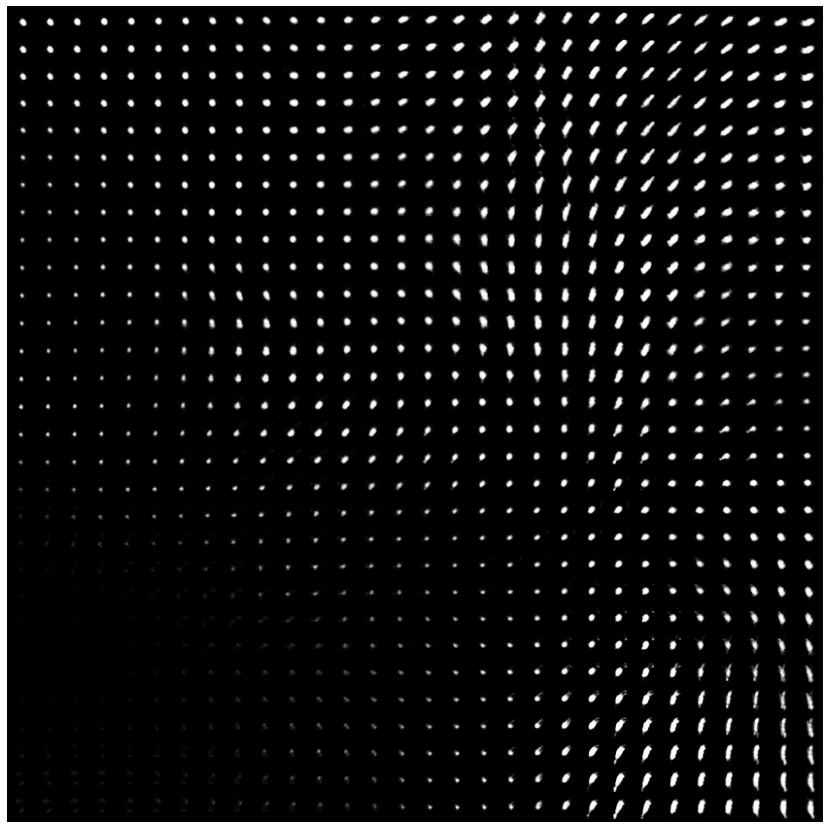

In [ ]:
from numpy.lib.function_base import digitize
import matplotlib.pyplot as plt

n = 30  # display a grid of 30x30 images, so 900 images total
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-1, 1, n)          # returns interval between -1 and 1, in 30 steps
grid_y = np.linspace(-1, 1, n)[::-1]    # same, backwards. 

for i, yi in enumerate(grid_y):
  for j, xi in enumerate(grid_x):    #iterate over grid locations

    # for each location, sample a digit and add it to our figure
    z_sample = np.array([[xi,yi]])  
    x_decoded = vae.decoder.predict(z_sample)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    figure[
           i * digit_size : (i + 1) * digit_size,
           j * digit_size : (j + 1) * digit_size,
           ] = digit

# Go plot all the images in a grid
plt.figure(figsize=(15,15))
start_range = digit_size // 2   # ?? //
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size) # https://numpy.org/doc/stable/reference/generated/numpy.arange.html
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)

plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")

[[-0.1  0.1]]


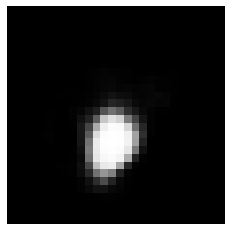

In [ ]:
# Generate a single image

xpos = -0.1 # from - 1 to 1
ypos = 0.1
seed = np.array([[xpos,ypos]])
print(seed)

generatedImage = vae.decoder.predict(seed)
generatedImage = generatedImage.reshape(28,28)
plt.axis("off")
plt.imshow(generatedImage, cmap="Greys_r")

In [ ]:
def generateIm(s):
  generatedImage = vae.decoder.predict(s)
  generatedImage = generatedImage.reshape(28,28)

  return generatedImage

Navigate latent space using sliders

[[ 0.778 -1.   ]]


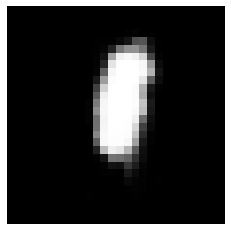

In [ ]:
#@title Latent Vector { run: "auto" }

# Interpolate images from vector
# Generate a single image

xpos = -0.592 #@param {type:"slider", min:-1, max:1, step:0.001}
ypos = -1 #@param {type:"slider", min:-1, max:1, step:0.001}
seed = np.array([[xpos,ypos]])
print(seed)

generated= generateIm(seed)
plt.axis("off")
plt.imshow(generated, cmap="Greys_r")


In [ ]:
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
from IPython.display import HTML

#@title Latent Vector { run: "auto" }
z1 = 0.019 #@param {type:"slider", min:-1, max:1, step:0.001}

nframes = 90
z2 = np.linspace(-1,1,nframes)

fig, ax = plt.subplots(figsize=(7,7))
plt.axis('off')
plt.set_cmap('gray')
plt.close()

def update(i):
  seed = np.array([[z1,z2[i]]])

  im = generateIm(seed)
  art=ax.imshow(im)
  return (art,)  
  
  
anim = FuncAnimation(fig, update, frames=np.arange(0,nframes), interval=200, blit=True)
rc('animation', html='jshtml')
anim

In [ ]:
# Save model
model = vae.decoder
model.save('/content/vaemodel')


INFO:tensorflow:Assets written to: /content/vaemodel/assets


[[-0.57 -0.5 ]]


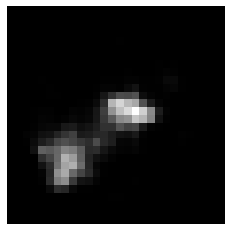

In [ ]:
#Reload saved model
new_model = keras.models.load_model('/content/vaemodel')

# Generate image from saved model
xpos = -0.57 # from - 1 to 1
ypos = -0.5
seed = np.array([[xpos,ypos]])
print(seed)

generatedImage = new_model.predict(seed)
generatedImage = generatedImage.reshape(28,28)
plt.axis("off")
plt.imshow(generatedImage, cmap="Greys_r")
